# Heart Disease Classification
Phase 3 Project by Bella Scribner
- Flex
- Morgan Jones
- Date of Project Review:
- Blog: 

# Introduction
- The Business + Buisness Problem
- Overview of project goals/what want to accomplish in order to 'solve' or address the business problem

1. Some nice intro about heart disease
    - paraphrase + cite Kaggle here
2. Business + Business Problem
    - Health care provider who would like model to predict wheather or not a patient has heart disease.  Can provide better care and hopefully catch more cases before someone becomes terminal
    - Recall is going to be important here -- missing someone with heart disease could be potentially fatal for the patient.  On the other hand, we do want to minimize false positives as well seeing as further screening and tests can have financial implications for the patients.  Thus we will want a nice balance between accuracy and recall for this model.

3. Let's dig into the data!

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, \
RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, \
accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

# Data Exploration

- What data working with + where sourced from

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# Ideally wanted 1000 rows for this project -- want to save as much info as can...

| Column | Description | 
|:----|:----|
| **Age** | Age of the patient | 
| **Sex** | Sex of the patient |
| **ChestPainType** | Chest Pain Type: Typical Angina (TA), Atypical Angina (ATA), Non-Anginal Pain (NAP), or Asymptomatic (ASY) |
| **RestingBP** | Resting blood pressure (mm Hg) |
| **Cholesterol** | Serum Cholesterol (mm/dl) |
| **FastingBS** | Fasting blood sugar: 1 if FastingBS > 120 mg/dl, otherwise 0 |
| **REstingECG** | Resting electrocardiogram results: Normal (Normal), Having ST-T wave abnormality (ST), Showing probable or definite left ventricular hypertrophy by Estes' criteria (LVH) | 
| **MaxHR** | Maximum heart rate achieved |
| **ExerciseAngina** | Yes if exercise-induced angina is present, otherwise No |
| **Oldpeak** | ST depression ('ST' relates to positions on the ECG plot) | 
| **ST_Slope** | The slope of the peak exercise ST segment: Upsloping (Up), Flat (flat), or Downsloping (Down) | 
| **HeartDisease** | Target: 1 if the patient has heart disease, otherwise 0 |

In [5]:
# Missing Values?
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
# Most Fasting Blood Sugars are not above the cuttoff of 120 mg/dl
# Check out 0 entries for: RestingBP and Cholesterol (missing values?)

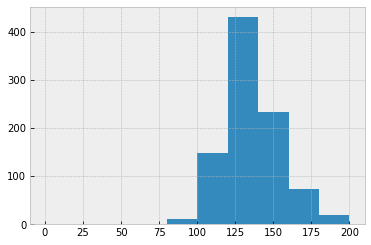

In [8]:
data['RestingBP'].hist();

In [9]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [10]:
# Only one entry of 0 Resting Blood Pressure - drop the entry.

In [11]:
data = data[data['RestingBP'] != 0]

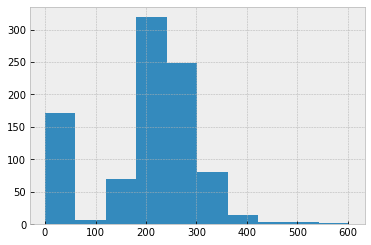

In [12]:
data['Cholesterol'].hist();

In [13]:
data[data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [14]:
data[data['Cholesterol'] == 0]['HeartDisease'].value_counts()

1    151
0     20
Name: HeartDisease, dtype: int64

In [15]:
data['HeartDisease'].value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

In [16]:
data['HeartDisease'].value_counts(normalize=True)

1    0.55289
0    0.44711
Name: HeartDisease, dtype: float64

In [17]:
# So, we have 171 entries with a zero value for Cholesterol. Of these, a vast majority are entires where the patient does
    # have heart disease.  We do not want to lose this many data points and will need to be very careful on the method
    # of which these missing values are filled.
    
# For now, we will replace values of 0 to NaN so an imputer of some sort can be utlized in later processing.

In [18]:
data.replace({'Cholesterol': {0 :np.nan}}, inplace=True)

In [19]:
data.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [20]:
# Take a peak at correlation

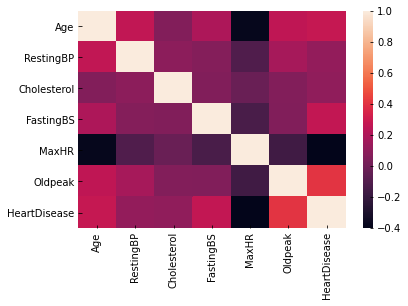

In [21]:
sns.heatmap(data.corr());

In [22]:
# Looks good!

# FROM HERE -->
    # more visualizations:  distrubution of target (maybe this earlier), scatter plot of target + variable(s) with strong 
    # correlation
    
    # Here is where dig into target variable and have small discusion on what metric(s) use to evaluate models
        # is accuracy a good one? yes/no + why? if not, what is?

# Data Pre-processing


In [23]:
# Split data
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, random_state = 7)

In [24]:
# Create Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state = 7)

In [25]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
661,49,M,NAP,118,149.0,0,LVH,126,N,0.8,Up
645,57,M,NAP,128,229.0,0,LVH,150,N,0.4,Flat
190,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up
415,66,F,ASY,155,NaN,1,Normal,90,N,0.0,Flat
188,50,F,ASY,120,328.0,0,Normal,110,Y,1.0,Flat


In [26]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# We will include FastingBS as this is an over/under cutt off value 

In [27]:
# Encoding of Categorical Data
X_encoded = ColumnTransformer(transformers = [("ohe", OneHotEncoder(handle_unknown="ignore", sparse = False),
                                                  cat_cols)], remainder = 'passthrough')

In [28]:
preprocess_pipe = Pipeline(steps = [
    ('encode', X_encoded),
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
])

In [29]:
# Scaling after encoding -- so for KNN all on same scale
# Impute mean (? -- check) for nans we created earlier
# only fit a pipeline at the end!

# Model Iteration 

- CREATE function to go through models + display results!!
- labels for pandas DF --> look at OHE documentation 
- Visualization of all models + results --> plotly library?
    - Confustion Matrix
    - Classification Report
    - Feature Importance (should be able to call on from model (if applicable)) -- maybe only do this one for final model?
- More full understanding of all the baseline models --> THEN gridsearch + data augmentation (to show skills)

In [30]:
# Logistic Regression
# KNN
# Classification Tree (?? Needed if doing Random Forest? ??)
# Random Forest
# XGBOOST

In [31]:
def all_metrics(model, X_set, y_true):
    """
    Takes in a fitted model or pipeline and returns the accuracy score, recall score,
    f1 score, precision score, and the confusion matrix using the values predicted from the 
    validation data.
    """
    # Predict
    y_preds = model.predict(X_set)
             
    # Accuracy
    accuracy = accuracy_score(y_true, y_preds)
       
    # Recall
    recall = recall_score(y_true, y_preds)
      
    # F1
    f1 = f1_score(y_true, y_preds)
        
    # Precision
    precision = precision_score(y_true, y_preds)
        
    # Confusion Matrix
    cnf_mtrx = confusion_matrix(y_true, y_preds)
    
    return accuracy, recall, f1, precision, cnf_mtrx

In [32]:
def model_comparison(models, X_set, y_true):
    """
    Description of function here!
    """
    
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    precision_scores = []
    confusion_matrices = []
    fitted_models = {}
    
    for model_tuple in models:
        model_name = model_tuple[0]
        model = model_tuple[1]
        
        # Create Pipeline with preprocess + current model
        pipe = Pipeline(steps=[
            ('preprocess', preprocess_pipe),
            (model_name, model)
        ])
        
        # Fit
        pipe.fit(X_train, y_train)
        fitted_models['{}'.format(model_name)] = pipe
        
        # Find Metrics
        accuracy, recall, f1, precision, cnf_mtrx = all_metrics(pipe, X_set, y_true)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)
        confusion_matrices.append(cnf_mtrx)
        
    return {'Accuracy': accuracy_scores, 'Recall': recall_scores, 'F1': f1_scores, 
           'Precision': precision_scores}, confusion_matrices, fitted_models

In [33]:
models = [('logistic_regression', LogisticRegression()), 
          ('knn', KNeighborsClassifier()), 
          ('classification_tree', DecisionTreeClassifier(random_state=7)), 
          ('random_forest', RandomForestClassifier(random_state=7)), 
          ('xgboost', XGBClassifier(random_state=7)) ]
metrics, confusion_matrices, fitted_models = model_comparison(models, X_val, y_val)

In [34]:
def graph_metrics(model_names, metrics_list):
    
    width = 0.15
    multiplier = 0
    x = np.arange(len(model_names))
    
    fig, ax = plt.subplots(figsize=(20,8))
    
    for score_name, score_data in metrics_list.items():
        offset = width * multiplier
        ax.bar(x + offset, score_data, width, label=score_name)
        multiplier +=1
        
    ax.set_xlabel('Model')
    ax.set_title('Model Metrics Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels(model_names)
    ax.legend();
    
    # To look up:
    # increase font size
    # move legend to out side of graph
    # add data points to top of graph bars

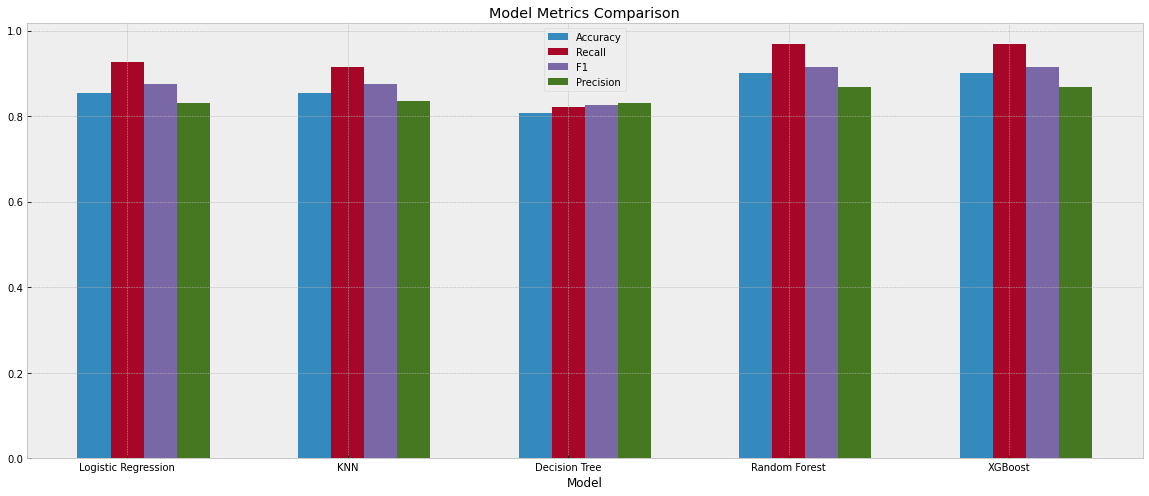

In [35]:
# Visualize each model's results
models_names = ('Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost')

graph_metrics(models_names, metrics)

### Add short interpretation here
- Logistic Regression is 'baseline'
- how other models did in comparison
- focus on accuracy and recall BUT don't want precision to be too low either

In [36]:
# Confusion Matrix for each model
# source:  https://medium.com/@eceisikpolat/plot-and-customize-multiple-confusion-matrices-with-matplotlib-a19ed00ca16c

def plot_cnf_matrices(cnf_matrices, model_names):

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharey=True, sharex=True)

    i = 0
    for cf in cnf_matrices:
        a = i // 3
        b = i % 3
    
        ax[a,b].set_title("{}".format(model_names[i]))
        disp = ConfusionMatrixDisplay(cf)
        disp.plot(ax=ax[a,b])
        i += 1
    
    fig.suptitle("Confusion Matrices")
    plt.show()

# To look up:
    # get rid of grid visual in bottom right corner

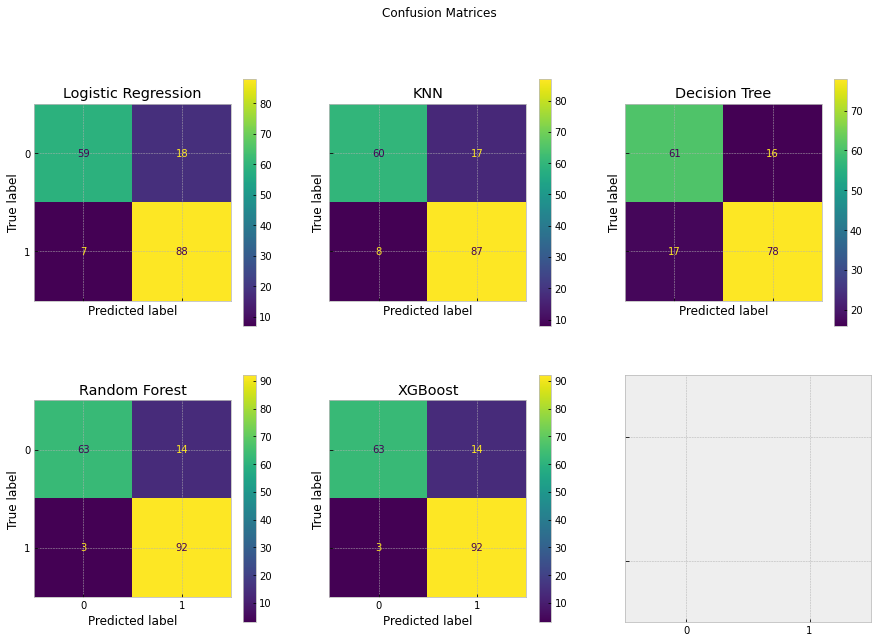

In [37]:
plot_cnf_matrices(confusion_matrices, models_names)

### Another small interpretation here
- Decision Tree is 'worst' while Random Forest and XGBoost seem to be doing best --> we will move forward with applying a grid search on these two models

In [38]:
def tuned_model_comparison(model_tuples, param_grids, scoring=None, random=False):
    
    best_results = {}
    
    for model_tuple, grid in zip(model_tuples, param_grids):
        
        # Build the estimator for the search
        model_name = model_tuple[0]
        model = model_tuple[1]
        estimator = Pipeline(steps=[
            ('preprocess', preprocess_pipe),
            (model_name, model)
        ])
        
        # Create Grid Search object
        skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 7)

        if random == True:
            gs_pipe = RandomizedSearchCV(estimator=estimator, param_distributions=grid, scoring=scoring, cv=skf)
        else:
            gs_pipe = GridSearchCV(estimator=estimator, param_grid=grid, scoring=scoring, cv=skf)
        
        # Fit
        gs_pipe.fit(X_train, y_train)
        
        # Results
        best_results[model_name] = {'estimator': gs_pipe.best_estimator_, 
                                   'params': gs_pipe.best_params_,
                                   'score': gs_pipe.best_score_}
    return best_results

In [39]:
# For Grid Search

forest_param_grid = {'random_forest__max_depth': [2, 8, 15, None],
               'random_forest__max_features': [1, 3, 'sqrt'],
               'random_forest__n_estimators': [10, 50, 100],
               'random_forest__min_samples_split': [30, 10, 2]}

xgb_param_grid = {'xgboost__learning_rate': [0.01, 0.1, 0.8],
                  'xgboost__max_depth': [2, 5, 15],
                  'xgboost__n_estimators': [50, 100, 200],
                  'xgboost__gamma': [0.1, 2, 5, 10]}

param_grids = [forest_param_grid, xgb_param_grid]

In [40]:
# For Randomized Grid Search

rand_forest_param_grid = {'random_forest__max_depth': stats.randint(2, 15),
               'random_forest__max_features': stats.uniform(0,1),
               'random_forest__n_estimators': stats.randint(10, 100),
               'random_forest__min_samples_split': stats.uniform(0.01, 0.99)}

rand_xgb_param_grid = {'xgboost__learning_rate': stats.uniform(0.01, 0.08),
                  'xgboost__max_depth': stats.randint(2, 15),
                  'xgboost__n_estimators': stats.randint(50,200),
                  'xgboost__gamma': stats.uniform(.1, 10)}

rand_param_grids = [rand_forest_param_grid, rand_xgb_param_grid]

In [41]:
tune_models = [('random_forest', RandomForestClassifier(random_state=7)), 
               ('xgboost', XGBClassifier(random_state=7)) ]

In [42]:
# Grid Search Results
best_models_std = tuned_model_comparison(tune_models, param_grids)
best_models_f1 = tuned_model_comparison(tune_models, param_grids, scoring='f1')
best_models_recall = tuned_model_comparison(tune_models, param_grids, scoring='recall')

# Randomized Search Results
best_models_rand = tuned_model_comparison(tune_models, rand_param_grids, random=True)
best_models_rand_f1 = tuned_model_comparison(tune_models, rand_param_grids, scoring='f1', random=True)
best_models_rand_recall = tuned_model_comparison(tune_models, rand_param_grids, scoring='recall', random=True)

In [43]:
searched_models = [best_models_std, best_models_f1, best_models_recall, 
                  best_models_rand, best_models_rand_f1, best_models_rand_recall]

rf_accuracy_scores = []
rf_recall_scores = []
rf_f1_scores = []
rf_precision_scores = []
rf_confusion_matrices = []
    
xgb_accuracy_scores = []
xgb_recall_scores = []
xgb_f1_scores = []
xgb_precision_scores = []
xgb_confusion_matrices = []

for model in searched_models:
   
    # Find and append metrics from the random forest model
    accuracy, recall, f1, precision, cnf_mtrx = all_metrics(model['random_forest']['estimator'], 
                                                           X_val, y_val)
    rf_accuracy_scores.append(accuracy)
    rf_recall_scores.append(recall)
    rf_f1_scores.append(f1)
    rf_precision_scores.append(precision)
    rf_confusion_matrices.append(cnf_mtrx)
    
    # Find and append metrics from the xgboost model
    accuracy, recall, f1, precision, cnf_mtrx = all_metrics(model['xgboost']['estimator'], 
                                                           X_val, y_val)
    xgb_accuracy_scores.append(accuracy)
    xgb_recall_scores.append(recall)
    xgb_f1_scores.append(f1)
    xgb_precision_scores.append(precision)
    xgb_confusion_matrices.append(cnf_mtrx)
    
# Create dictionary of metrics for each model type
rf_metrics = {'Accuracy': rf_accuracy_scores, 'Recall': rf_recall_scores, 'F1': rf_f1_scores, 
           'Precision': rf_precision_scores}
xgb_metrics = {'Accuracy': xgb_accuracy_scores, 'Recall': xgb_recall_scores, 'F1': xgb_f1_scores, 
           'Precision': xgb_precision_scores}

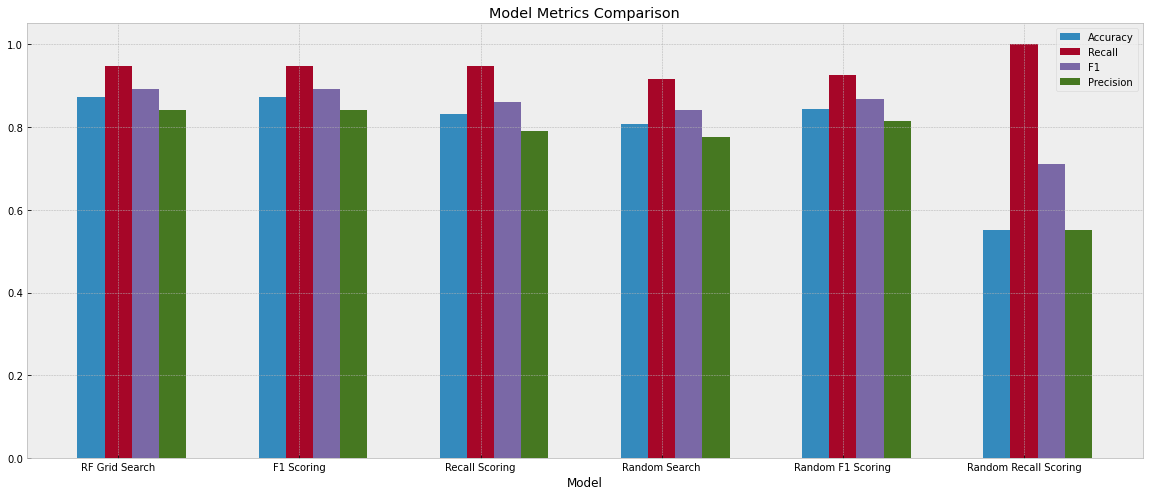

In [44]:
# Graph Random Forest Search Results
rf_names = ['RF Grid Search', 'F1 Scoring', 'Recall Scoring', 'Random Search', 
            'Random F1 Scoring', 'Random Recall Scoring']
graph_metrics(rf_names, rf_metrics)

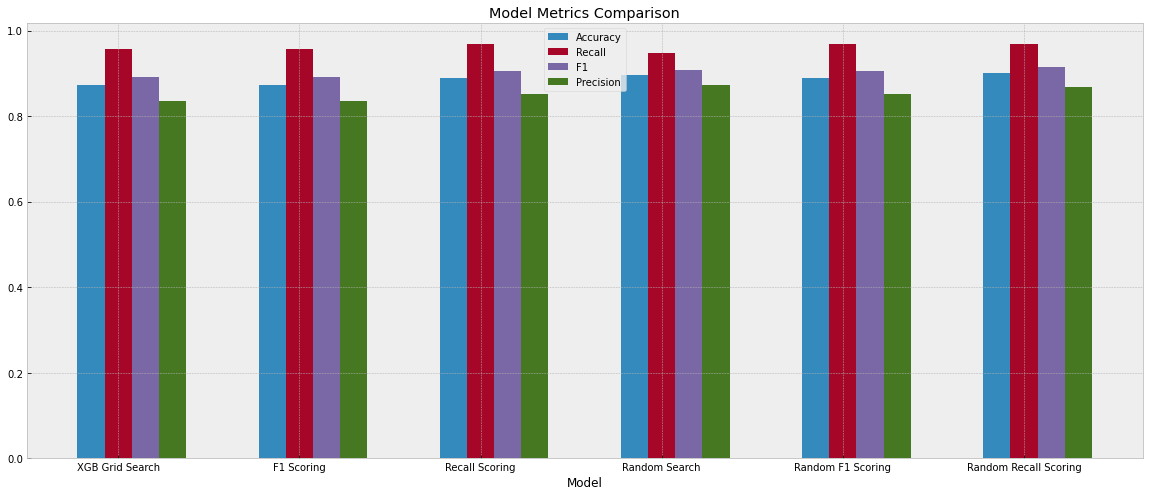

In [45]:
# Graph XGBoost Search Results
xgb_names = ['XGB Grid Search', 'F1 Scoring', 'Recall Scoring', 'Random Search', 
             'Random F1 Scoring', 'Random Recall Scoring']
graph_metrics(xgb_names, xgb_metrics)

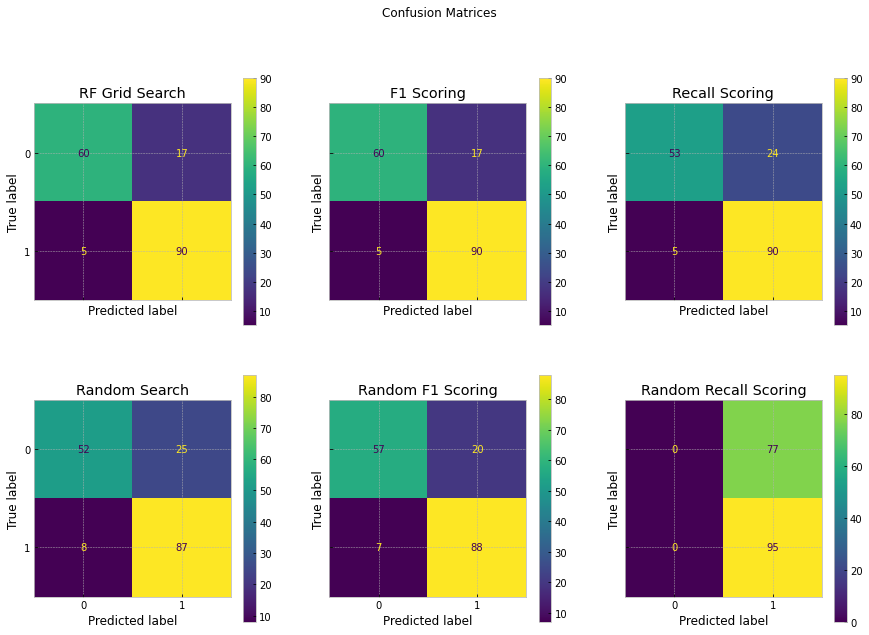

In [46]:
# Confusion Matrices for Random Forest Search Results
plot_cnf_matrices(rf_confusion_matrices, rf_names)

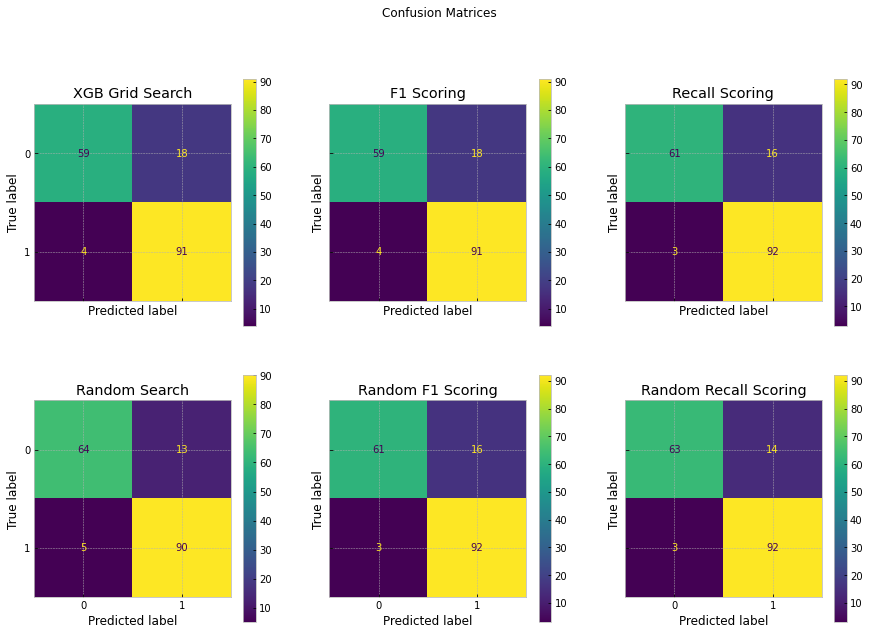

In [47]:
# Confusion Matrices for XGBoost Search Results
plot_cnf_matrices(xgb_confusion_matrices, xgb_names)

In [48]:
# XGBoost w/ Random Search, Recall Scoring
# XGBoost, default params
# Random Forest default params

### Add Interpretation Here
- Three models all with the same results! (metrics all the same!)
- choose XGBoost without random search --> xgboost tends to outperform random forest, but not random search (search found that the default parameters work best anyhow).

# Final Model
- Details on Final Model + recommendations
    - model features - which ones important to model?
    - how well can model predict target?
    - contexts/situations where the predictions made by model would and would not be useful for your stakeholder and business problem
    - what should stakeholders DO with this information??
    - suggestions for how the buisness might modify certain input variables to achieve certain target results
    - ETC...
    - Limitations/Uncertainty in project?

In [49]:
final_model = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('xgboost', XGBClassifier(random_state=7))
])
final_model.fit(X_train_all, y_train_all)
all_metrics(final_model, X_test, y_test)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('encode',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'FastingBS',
                                                                    'RestingECG',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope'])])),
                                 ('num_impute', SimpleImputer()),
            

In [50]:
# Feature importance --> how do I pull this out of the model again?

In [51]:
## REMEMBER:
# Accuracy: how often model is correct overall
# Recall: how well can model find all objects of the target class
# Precision: how often the model is correct when predicting the target class